# Score: 97.642%

This is all Yassine Ghouzam's [code](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6).  I'm going to try and improve from here.  Learned some nice pandas tricks along the way

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv("/Users/pbezuhov/git/Kaggle/data/mnist/train.csv")
test = pd.read_csv("/Users/pbezuhov/git/Kaggle/data/mnist/test.csv")

In [2]:
train_y = train['label']
train_x = train.drop(['label'], axis=1)

In [3]:
# Normalize
train_x = train_x / 255.0
test = test / 255.0

In [4]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
train_x = train_x.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [5]:
from keras.utils.np_utils import to_categorical

train_y = to_categorical(train_y, num_classes = 10)

Using TensorFlow backend.


In [6]:
# Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1, random_state=2)

In [7]:
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, MaxPool2D, Flatten

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [8]:
from keras.optimizers import RMSprop

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [9]:
from keras.callbacks import ReduceLROnPlateau

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 1 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [10]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_x)

In [11]:
# Fit the model
history = model.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                              epochs = epochs, validation_data = (val_x, val_y),
                              verbose = 2, steps_per_epoch=train_x.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/1
 - 531s - loss: 0.4383 - acc: 0.8573 - val_loss: 0.0640 - val_acc: 0.9805


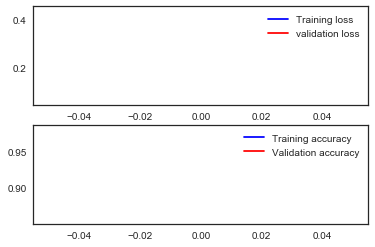

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='white', context='notebook', palette='deep')

# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

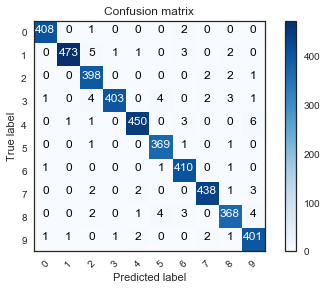

In [31]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
pred_y = model.predict(val_x)
# Convert predictions classes to one hot vectors 
pred_y_classes = np.argmax(pred_y, axis=1) 
# Convert validation observations to one hot vectors
true_y = np.argmax(val_y, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(true_y, pred_y_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

In [33]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [35]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("../submissions/not_my_code.csv",index=False)